In [4]:
import cv2
image_path = '/data/coding/images/2025-06-05/down/2.bmp'
if not image_path:
    print("Error image path!")
    quit()
image = cv2.imread(image_path)
print(image.shape[2])
print(f"图像的原始数据类型 (dtype): {image.dtype}") 

3
图像的原始数据类型 (dtype): uint8


# automatically generate and anaylsis the mask using SAM
The overall precedure of our pipeline is:
1. install and import the libraries and functions used
2. import the images recursively
3. using Hough transformation to determine the mask of the agar plate
4. calculate the pixels of the mask, and then cut the 

firstly, set up the envionment of `opencv-python`, `CUDA>=11.8`, `python>=3.8`, as well as `pytorch>=1.7` and `torchvision>=0.8`. The program is tested under NVIDIA Tesla P4 (8GB) with `CUDA==12.4, pytorch==2.4.1`, and `python==3.10.16`:

`pip install segment-anything`

Afterwards, download the `vit_h` file in the github repo. of segment-anything via:

`wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth`

In [16]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)
def create_petri_dish_mask_hough_optimized(image_path, resize_width=500):
    """
    使用优化后的霍夫圆变换来识别培养皿。
    返回: 
    - result_image: 带有绿色检测圆圈的原图副本。
    - mask: 黑白的蒙版图像。
    - masked_original: 应用了蒙版的原图。
    """
    # 1. 加载图像
    original_image = cv2.imread(image_path)
    if original_image is None:
        print(f"Image load failed. Please check the path of image: {image_path}")
        return None, None, None
        
    # 2. 预处理：缩小图像尺寸以加快处理速度
    original_height, original_width = original_image.shape[:2]
    scale = resize_width / original_width
    resized_height = int(original_height * scale)
    resized_image = cv2.resize(original_image, (resize_width, resized_height))
    
    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    
    # 使用高斯模糊代替中值模糊，对于霍夫变换通常效果更好且稍快
    gray_blurred = cv2.GaussianBlur(gray, (9, 9), 2)

    # 3. 执行霍夫圆检测 (参数已调整)
    circles = cv2.HoughCircles(
        gray_blurred, 
        cv2.HOUGH_GRADIENT, 
        dp=1.2, 
        minDist=int(resize_width / 2),
        param1=100, 
        param2=40,
        minRadius=int(resize_width * 0.3), 
        maxRadius=int(resize_width * 0.55)
    )

    mask = None
    masked_original = None
    result_image = original_image.copy() # 在原图上绘制结果
    
    if circles is not None:
        # 将检测到的圆的坐标和半径按比例还原到原始图像尺寸
        best_circle = circles[0, 0]
        center_resized = (int(best_circle[0]), int(best_circle[1]))
        radius_resized = int(best_circle[2])
        
        # 还原到原图坐标
        center_original = (int(center_resized[0] / scale), int(center_resized[1] / scale))
        radius_original = int(radius_resized / scale)
        
        # 4. 在原始尺寸的空mask上绘制白色实心圆
        mask = np.zeros(original_image.shape[:2], dtype=np.uint8)
        cv2.circle(mask, center_original, radius_original, 255, -1)
        
        # 在原图上画出检测到的圆以供可视化
        cv2.circle(result_image, center_original, radius_original, (0, 255, 0), 10)

        # 5. 【新增】使用蒙版提取原图中的培养皿区域
        masked_original = cv2.bitwise_and(original_image, original_image, mask=mask)

    return result_image, mask, masked_original


Then, import the image that is processing:

In [17]:
image_path = '/data/coding/images/2025-05-21/down1.jpg'
if not image_path:
    print("Error image path!")
    quit()
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

Afterwards, use OpenCV to generate a mask for the agar plate: 

In [18]:
def calculate_shape_properties(mask):
    """
    Calculates the pixel count, roundness, and anisotropy of a binary mask.

    Args:
        mask (np.array): A 2D numpy array representing the binary mask (0 for background, non-zero for foreground).

    Returns:
        dict: A dictionary containing the calculated properties. Returns None if no contours are found.
    """
    # Ensure the mask is a binary image of type uint8
    if mask.dtype != np.uint8:
        mask = np.uint8(mask > 0) * 255

    # 1. Calculate Pixel Count
    pixel_count = cv2.countNonZero(mask)
    
    if pixel_count == 0:
        return {
            "pixel_count": 0,
            "roundness": 0,
            "anisotropy": 0
        }

    # Find contours in the mask
    # cv2.RETR_EXTERNAL is used to retrieve only the extreme outer contours.
    # cv2.CHAIN_APPROX_SIMPLE compresses horizontal, vertical, and diagonal segments, leaving only their end points.
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return None # No contours found

    # Assuming the largest contour corresponds to the main object
    main_contour = max(contours, key=cv2.contourArea)

    # --- Property Calculations ---

    # Get Area from contour
    area = cv2.contourArea(main_contour)

    # Get Perimeter from contour
    perimeter = cv2.arcLength(main_contour, True) # True indicates it's a closed contour

    # 2. Calculate Roundness
    if perimeter == 0:
        roundness = 0
    else:
        # Using the formula: 4 * pi * Area / (Perimeter^2)
        roundness = (4 * np.pi * area) / (perimeter**2)

    # 3. Calculate Anisotropy (Elongation)
    # The contour needs at least 5 points to fit an ellipse
    if len(main_contour) < 5:
        anisotropy = 1  # Cannot fit ellipse, assume it's point-like or a line, default to 1
    else:
        # Fit an ellipse to the contour
        (x, y), (MA, ma), angle = cv2.fitEllipse(main_contour)
        
        # Avoid division by zero for the minor axis
        if ma == 0:
            # If minor axis is 0, it's essentially a line, which is infinitely anisotropic
            anisotropy = float('inf')
        else:
            # Anisotropy is the ratio of Major Axis to Minor Axis
            anisotropy = MA / ma

    return {
        "pixel_count": pixel_count,
        "roundness": roundness,
        "anisotropy": anisotropy
    }
result_image, plate_result_mask, plate_masked_image = create_petri_dish_mask_hough_optimized(image_path)
plate_pix = calculate_shape_properties(plate_result_mask)["pixel_count"] 
# plate_pix: the number of pixel in the plate
print(plate_pix)
# show the predicted mask
image = plate_masked_image
image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
plt.imshow(cv2.cvtColor(plate_masked_image, cv2.COLOR_BGR2RGB))
plt.title('the image of masked plate')
plt.axis('on')

AttributeError: 'NoneType' object has no attribute 'dtype'

: 

After checking the masked plate, import something from segment-anything:

In [12]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
predictor.set_image(image)

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

/data/miniconda/envs/torch/lib/python3.10/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


## Specifying a specific object with a box
The model can also take a box as input, provided in xyxy format.

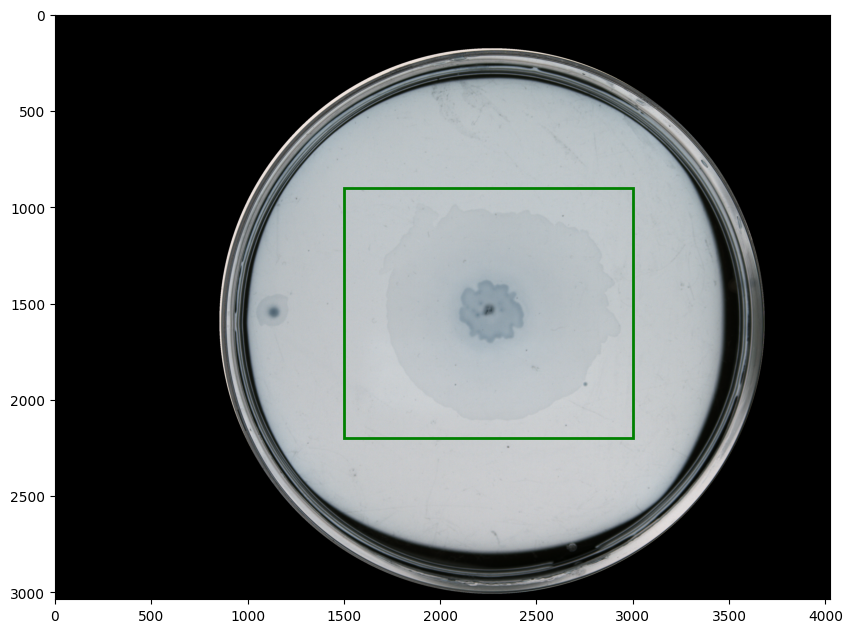

In [13]:
input_box = np.array([1500, 2200, 3000, 900])
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_box(input_box, plt.gca())
plt.axis('on')
plt.show()

After choosing a perfect rectangle, just let the model think think its boundary:

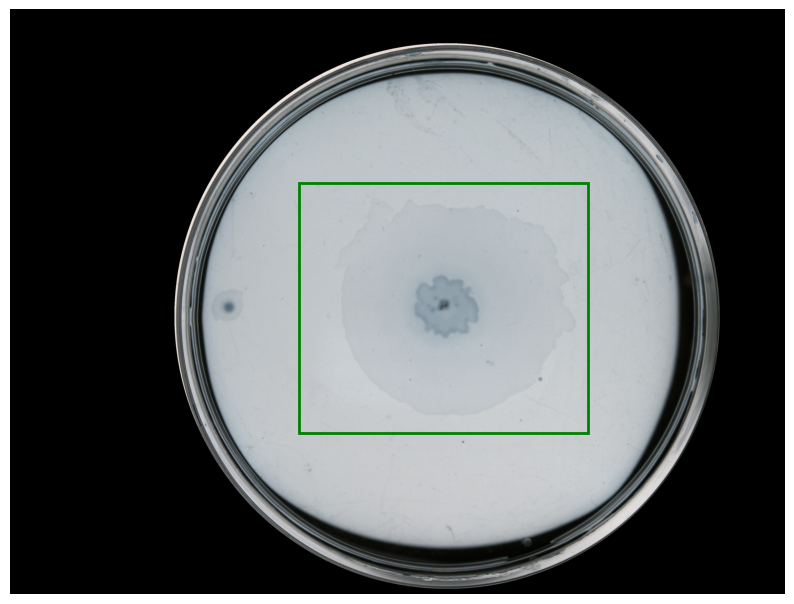

0


In [14]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

mask_pix = calculate_shape_properties(masks[0])["pixel_count"] 
print(mask_pix)